<a href="https://colab.research.google.com/github/LuccaMello7/Portfolio/blob/main/DataAnalyticsTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Teste desenvolvido para a vaga de `Data Analytics Sênior` da Enjoei

<img src="https://s3.amazonaws.com/gupy5/production/socialmedias/1118/f31b79aaa8939cf79735f6f06f1dccf2_logo-enjoei.png" width="750" height = "380">

**Case**:

Imagine que você faz parte do time de Analytics do enjoei e é responsável por prover insights e guiar as decisões do squad que faz parte.
Nesse quarter o *objetivo é reverter a tendência de vendas*, que caiu ao longo do **último quarter**.

Para visualizar os dados disponíveis, basta acessar o db que preparamos no link abaixo:

**Perguntas**:



*   Quais são as aparentes causas para a queda de venda? Tente entender os principais gargalos no funil de vendas e levantar hipóteses do que
pode ter causado cada comportamento
*   Existem outras informações que seriam úteis para sua análise?
Por quê? Que respostas teríamos com essas informações adicionais?

*   Você consegue pensar em outras análises que ajudariam a alcançar o objetivo desse
quarter?
Descreva as análises e os seus benefícios e impactos nas decisões do squad.


In [1]:
#Criar acesso para que o notebook consiga visualizar o Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install folium --upgrade

In [3]:
#Importação das bibliotecas necessárias para a análise
!pip install pandasql
import os
import pandas as pd
import numpy as np
import seaborn as sns
import plotly as plot
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn.apionly as sns
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)
from pandasql import sqldf
import warnings
warnings.filterwarnings('ignore')
#Importar arquivos para leitura
df_funnel =  pd.read_csv('/content/drive/MyDrive/bq-results-20220409-034935-1649476184031/funnel.csv')

df_orders = pd.read_csv('/content/drive/MyDrive/bq-results-20220409-034813-1649476106353/orders.csv')

/usr/local/lib/python3.7/dist-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [4]:
#Ler os 5 primeiros registros do nosso dataframe 'Orders'
df_orders.head()

order_id     sold_at  seller_id  buyer_id  product_id shipped_at  \
0    518069  2020-06-19     783168    516403      430686        NaN   
1    518098  2020-06-19     693688    826469      246600        NaN   
2    518110  2020-06-19     954809    135963       37480        NaN   
3    518216  2020-06-19     226353     96858      667615        NaN   
4    518555  2020-06-19     504580    908294       82804        NaN   

  order_status  order_value  
0     canceled       105.71  
1     canceled       179.25  
2     canceled        91.91  
3     canceled       177.73  
4     canceled       134.20

<img src="https://assets.materialup.com/uploads/99e039b8-6819-459c-868f-3c114cfa3bd2/preview.jpg" width="500" height = "300">

# Um Overview dos nossos dados

Vamos verificar abaixo o que temos de informação útil e o que os nossos datasets nos falam, para que possamos ser mais assertivos na nosssa análise





In [5]:
#Coleção dos nossos datasets
datasets = [df_orders, df_funnel]

nomes = ['df_orders', 'df_funnel']

#Criar um dataframe com informações úteis sobre os outros datasets

data_info = pd.DataFrame({})
data_info['dataset'] = nomes
data_info['numero_de_linhas'] = [df.shape[0] for df in datasets]
data_info['numero_de_colunas'] = [df.shape[1] for df in datasets]
data_info['dados_ausentes'] = [df.isnull().sum().sum() for df in datasets]
data_info['qtd_colunas_nulas'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info['colunas_com_valores_nulos'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info.style.background_gradient()

#Detectando Outliers em nosso dataset

<img src='https://media.nagwa.com/734132721402/en/thumbnail_l.jpeg' width="600" height = "280">

Existem algumas formas de detectar Outliers, por exemplo:



*   Usar método chamado `describe()` que fornece uma resumo estatístico
*   Plotar o famoso `Gráfico de Caixa (boxplots)` nas variáveis



In [6]:
df_orders[['order_id', 'sold_at', 'seller_id', 'buyer_id', 'product_id', 'shipped_at', 'order_status', 'order_value']].describe()

order_id      seller_id       buyer_id     product_id  \
count  100125.000000  100125.000000  100125.000000  100125.000000   
mean   478963.000000  498879.772175  503313.609508  498389.457199   
std     28903.742189  287127.873973  288723.822438  288628.897595   
min    428901.000000      89.000000       6.000000       6.000000   
25%    453932.000000  257645.000000  250913.000000  247568.000000   
50%    478963.000000  489709.000000  508893.000000  497624.000000   
75%    503994.000000  748841.000000  754269.000000  747298.000000   
max    529025.000000  999873.000000  999949.000000  999995.000000   

         order_value  
count  100125.000000  
mean      137.285573  
std        61.269339  
min        45.000000  
25%        86.510000  
50%       130.130000  
75%       178.120000  
max       314.990000

In [7]:
df_funnel[['date', 'visits', 'product_views','carts_created']].describe()

visits  product_views  carts_created
count     91.000000      91.000000      91.000000
mean   20844.648352   24824.054945    2607.032967
std     2003.111199    2907.604292     318.403917
min    17100.000000   18737.000000    1968.000000
25%    18487.000000   22678.500000    2421.000000
50%    21650.000000   25124.000000    2634.000000
75%    22332.000000   26948.000000    2801.000000
max    23544.000000   30577.000000    3310.000000

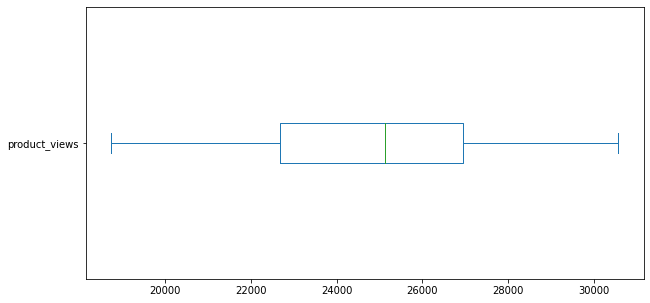

In [8]:
# Usarei somente a coluna 'Product Views' para plotar um BoxPlot já que criaremos uma função logo abaixo para remover os Outliers de nossos dataframes. 
# Mas fica o registro das duas situações acima onde pudemos detectar os outliers de maneira fácil.

df_funnel['product_views'].plot(kind = 'box', vert=False,figsize = (10,5))
plt.show()

In [9]:
#Vamos escrever uma função para detectar a existência de Outliers em nosso dataframe

def outlier_detect(df):

    for i in df.describe().columns:
        Q1 = df.describe().at['25%',i]
        Q3 = df.describe().at['75%',i]

        INTERVALO_ENTRE_QUARTIS = Q3 - Q1
        LIMITE_INFERIOR = Q1 - 1.5 * INTERVALO_ENTRE_QUARTIS
        LIMITE_SUPERIOR = Q3 + 1.5 * INTERVALO_ENTRE_QUARTIS

        x = np.array(df[i])
        valor_outlier = []
        for j in x:
            if j < LIMITE_INFERIOR or j > LIMITE_SUPERIOR:
                valor_outlier.append(df[i].median())
            else:
                valor_outlier.append(j)
        print('\033[1m' + '\n Outliers for Column : ', i, ' Outliers count ', len(valor_outlier))
        print(valor_outlier)
        df[i] = valor_outlier
    #Retorna um novo Dataframe sem Outliers    
    return df

<img src="https://static.vecteezy.com/ti/vetor-gratis/p3/3003279-conceitos-de-limpeza-de-dados-vetor.jpg" width="300" height = "300">

# Aplicar a função criada para detectar e remover os Outliers nos nossos datasets

In [10]:
#Passando nosso dataset df_funnel como parâmetro de nossa função para limparmos os dados que não serão úteis para nossa análise.
outlier_detect(df_funnel)


 Outliers for Column :  visits  Outliers count  91
[22096, 20300, 22127, 18412, 21911, 22718, 21997, 22513, 22896, 18275, 17630, 20710, 21757, 21135, 22153, 21330, 21152, 22761, 21859, 22315, 17238, 22131, 23182, 18286, 21650, 23520, 18662, 23162, 17335, 22407, 21890, 17100, 23544, 22267, 18162, 21564, 17854, 17234, 17975, 21796, 23026, 22349, 21420, 21211, 17735, 18031, 23040, 21240, 20970, 22899, 18107, 22285, 17460, 17760, 21010, 21878, 22448, 22621, 18155, 21058, 17351, 20597, 17981, 22042, 17856, 17589, 22712, 22652, 21650, 22512, 21456, 18546, 21428, 21270, 20478, 21686, 22030, 21714, 22670, 18547, 21973, 22576, 21624, 22768, 18428, 23334, 23379, 17458, 22024, 21885, 20938]

 Outliers for Column :  product_views  Outliers count  91
[30577, 28215, 28198, 21885, 22663, 25254, 28790, 30246, 24387, 20495, 22437, 27447, 27834, 27109, 24829, 25124, 28692, 25782, 28580, 29749, 23656, 25354, 27318, 20089, 26275, 24662, 20809, 27295, 23112, 26787, 23555, 21092, 25928, 24903, 20610, 22694

date  visits  product_views  carts_created
0   2020-04-22   22096          30577           3072
1   2020-04-03   20300          28215           3082
2   2020-04-23   22127          28198           3085
3   2020-06-14   18412          21885           2318
4   2020-05-19   21911          22663           2330
..         ...     ...            ...            ...
86  2020-06-18   23379          23545           2550
87  2020-04-19   17458          23609           2552
88  2020-06-26   22024          26325           2811
89  2020-04-09   21885          27904           2812
90  2020-05-01   20938          25246           2559

[91 rows x 4 columns]

In [11]:
#Passando nosso dataset df_orders como parâmetro de nossa função para limparmos os dados que não serão úteis para nossa análise.
outlier_detect(df_orders)


 Outliers for Column :  order_id  Outliers count  100125
[518069, 518098, 518110, 518216, 518555, 518638, 518085, 518139, 518562, 518389, 517783, 517791, 517813, 517984, 518407, 518105, 518168, 517742, 518378, 518512, 517929, 517944, 518197, 518258, 518635, 517770, 518217, 518455, 518491, 518539, 518614, 517858, 517767, 517849, 518509, 517915, 518022, 518273, 518340, 518359, 518485, 518650, 517730, 517734, 517854, 517940, 518516, 518655, 517836, 518159, 518532, 518574, 517899, 517963, 518032, 518242, 518629, 517737, 517945, 517981, 518065, 518419, 518507, 517861, 518089, 518163, 518199, 518358, 517751, 518180, 518264, 518321, 518584, 517769, 518204, 518520, 518546, 518553, 518072, 518424, 518529, 518591, 517824, 517891, 518036, 518115, 518348, 518366, 517773, 517906, 517956, 518012, 518254, 518653, 518347, 518369, 518405, 518557, 518628, 517807, 517991, 517994, 518049, 518278, 518376, 517841, 517916, 518390, 518129, 518172, 518402, 517840, 517989, 518103, 517759, 517868, 517951, 51796

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



order_id     sold_at  seller_id  buyer_id  product_id  shipped_at  \
0         518069  2020-06-19     783168    516403      430686         NaN   
1         518098  2020-06-19     693688    826469      246600         NaN   
2         518110  2020-06-19     954809    135963       37480         NaN   
3         518216  2020-06-19     226353     96858      667615         NaN   
4         518555  2020-06-19     504580    908294       82804         NaN   
...          ...         ...        ...       ...         ...         ...   
100120    516964  2020-06-18     163113    108843      539059  2020-06-18   
100121    517319  2020-06-18     722425    133394       15067  2020-06-18   
100122    517584  2020-06-18      55346    301664       31908  2020-06-18   
100123    517610  2020-06-18      60310    447732      301470  2020-06-18   
100124    516758  2020-06-18     430274    499654      174351  2020-06-18   

       order_status  order_value  
0          canceled       105.71  
1          canceled       179.25  
2          canceled        91.91  
3          canceled       177.73  
4          canceled       134.20  
...             ...          ...  
100120    completed       183.05  
100121    completed       124.33  
100122    completed       127.94  
100123    completed        64.62  
100124    completed       135.83  

[100125 rows x 8 columns]

In [12]:
#Converter coluna de datas para datetime
df_funnel['date'] = pd.to_datetime(df_funnel['date'], dayfirst = True)

#Criar as colunas de ano, mês, e dia
df_funnel['dia'] = df_funnel['date'].dt.day
df_funnel['mes'] = df_funnel['date'].dt.month
df_funnel['ano'] = df_funnel['date'].dt.year
df_funnel['quarter'] = df_funnel['date'].dt.quarter

#Identificar e mapear qual dia da semana foi inserido o resultado na base 
dw_mapping={
    0: 'Segunda', 
    1: 'Terça', 
    2: 'Quarta', 
    3: 'Quinta', 
    4: 'Sexta',
    5: 'Sábado', 
    6: 'Domingo'
} 
df_funnel['dia_da_semana']= df_funnel['date'].dt.weekday.map(dw_mapping)

In [13]:
#Converter coluna de datas para datetime
df_orders['sold_at'] = pd.to_datetime(df_orders['sold_at'], dayfirst = True)

#Criar as colunas de ano, mês, e dia
df_orders['dia'] = df_orders['sold_at'].dt.day
df_orders['mes'] = df_orders['sold_at'].dt.month
df_orders['ano'] = df_orders['sold_at'].dt.year
df_orders['quarter'] = df_orders['sold_at'].dt.quarter
df_orders['nome_do_mes'] = df_orders['sold_at'].apply(lambda x: x.strftime('%b'))
df_orders['mes_ano'] = df_orders['sold_at'].apply(lambda x: x.strftime('%m%Y'))

#Identificar e mapear qual dia da semana foi inserido o resultado na base 
dw_mapping={
    0: 'Segunda', 
    1: 'Terça', 
    2: 'Quarta', 
    3: 'Quinta', 
    4: 'Sexta',
    5: 'Sábado', 
    6: 'Domingo'
} 
df_orders['dia_da_semana']= df_orders['sold_at'].dt.weekday.map(dw_mapping)


In [14]:
df_orders.head(10)

order_id    sold_at  seller_id  buyer_id  product_id shipped_at  \
0    518069 2020-06-19     783168    516403      430686        NaN   
1    518098 2020-06-19     693688    826469      246600        NaN   
2    518110 2020-06-19     954809    135963       37480        NaN   
3    518216 2020-06-19     226353     96858      667615        NaN   
4    518555 2020-06-19     504580    908294       82804        NaN   
5    518638 2020-06-19     321501    907150      967684        NaN   
6    518085 2020-06-19     399827    862203      548851        NaN   
7    518139 2020-06-19     946504      4220       22864        NaN   
8    518562 2020-06-19     922788    514707      850107        NaN   
9    518389 2020-06-19     206792    254552       21828        NaN   

  order_status  order_value  dia  mes   ano  quarter nome_do_mes mes_ano  \
0     canceled       105.71   19    6  2020        2         Jun  062020   
1     canceled       179.25   19    6  2020        2         Jun  062020   
2     canceled        91.91   19    6  2020        2         Jun  062020   
3     canceled       177.73   19    6  2020        2         Jun  062020   
4     canceled       134.20   19    6  2020        2         Jun  062020   
5     canceled       170.01   19    6  2020        2         Jun  062020   
6     canceled       145.50   19    6  2020        2         Jun  062020   
7     canceled       191.17   19    6  2020        2         Jun  062020   
8     canceled       162.59   19    6  2020        2         Jun  062020   
9     canceled       130.56   19    6  2020        2         Jun  062020   

  dia_da_semana  
0         Sexta  
1         Sexta  
2         Sexta  
3         Sexta  
4         Sexta  
5         Sexta  
6         Sexta  
7         Sexta  
8         Sexta  
9         Sexta

#Número de Visitantes por Data

Para analisar o número de visitantes por data, agrupamos o conjunto de dados pelas colunas `sold_at` e `user_id`. O número de visitantes em cada data é extraído e mostrado no gráfico abaixo.



*   Baseado no gráfico abaixo vemos que o pico de visitantes ocorreu numa `Quarta-feira`

Faremos uma nova análise comportamental a seguir para entendermos quais os dias da semana nossos clientes converteram em compras as suas visitas no site, classificados por dias da semana.



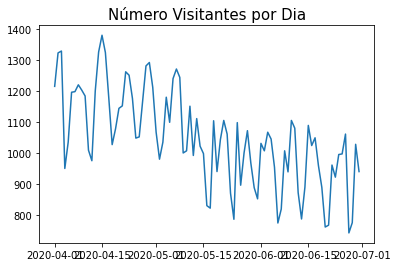

In [15]:
from datetime import datetime
#No of visitors by date
data = df_orders.loc[:,['sold_at','buyer_id']]
#Extracting only dates
data['sold_at'] = data['sold_at'].apply(lambda s: str(s)[0:10])
visitor_by_date = data.drop_duplicates().groupby(['sold_at'])['buyer_id'].agg(['count']).sort_values(by=['sold_at'], ascending=True)
x = pd.Series(visitor_by_date.index.values).apply(lambda s: datetime.strptime(s, '%Y-%m-%d').date())
y = visitor_by_date['count']
plt.title('Número Visitantes por Dia', fontsize = 15)
plt.rcParams['figure.figsize'] = (20,8)

plt.plot(x,y)
plt.show()

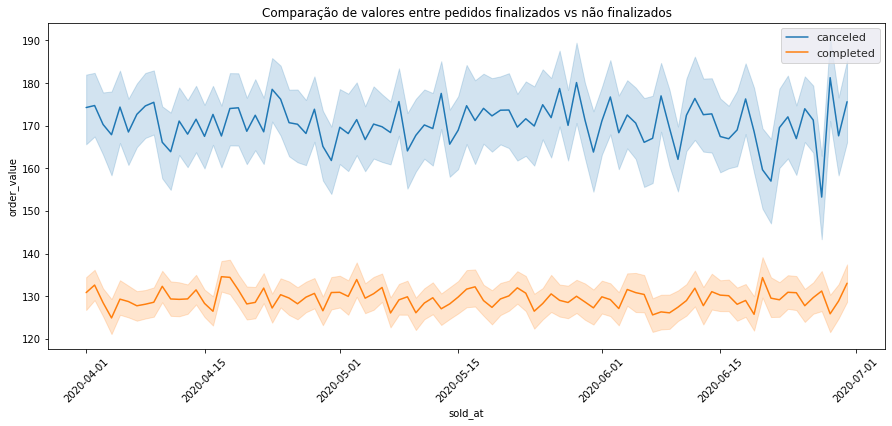

In [16]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.set(palette='muted', color_codes=True)
ax = sns.lineplot(x='sold_at', y='order_value', data=df_orders.query("order_status == 'canceled'"), label='canceled')
ax = sns.lineplot(x='sold_at', y='order_value', data=df_orders.query("order_status == 'completed'"), label='completed')
ax.set_title('Comparação de valores entre pedidos finalizados vs não finalizados', fontsize = 12)
ax.tick_params(axis='x', labelrotation=45)
plt.show()

#Criar um Dataframe onde somente as vendas concretizadas aparecem

In [17]:
vendas_concretizadas_df = df_orders[df_orders['order_status'] == 'completed']
vendas_concretizadas_df




order_id    sold_at  seller_id  buyer_id  product_id  shipped_at  \
168       517746 2020-06-19     694527      5120      914732  2020-06-19   
169       518270 2020-06-19     997935    975645       21230  2020-06-19   
170       518287 2020-06-19      13300    492481      468595  2020-06-19   
171       518006 2020-06-19      88091    870074      199162  2020-06-19   
172       518086 2020-06-19     412705    710028      688649  2020-06-19   
...          ...        ...        ...       ...         ...         ...   
100120    516964 2020-06-18     163113    108843      539059  2020-06-18   
100121    517319 2020-06-18     722425    133394       15067  2020-06-18   
100122    517584 2020-06-18      55346    301664       31908  2020-06-18   
100123    517610 2020-06-18      60310    447732      301470  2020-06-18   
100124    516758 2020-06-18     430274    499654      174351  2020-06-18   

       order_status  order_value  dia  mes   ano  quarter nome_do_mes mes_ano  \
168       completed        70.29   19    6  2020        2         Jun  062020   
169       completed        76.25   19    6  2020        2         Jun  062020   
170       completed       172.46   19    6  2020        2         Jun  062020   
171       completed        73.14   19    6  2020        2         Jun  062020   
172       completed        78.55   19    6  2020        2         Jun  062020   
...             ...          ...  ...  ...   ...      ...         ...     ...   
100120    completed       183.05   18    6  2020        2         Jun  062020   
100121    completed       124.33   18    6  2020        2         Jun  062020   
100122    completed       127.94   18    6  2020        2         Jun  062020   
100123    completed        64.62   18    6  2020        2         Jun  062020   
100124    completed       135.83   18    6  2020        2         Jun  062020   

       dia_da_semana  
168            Sexta  
169            Sexta  
170            Sexta  
171            Sexta  
172            Sexta  
...              ...  
100120        Quinta  
100121        Quinta  
100122        Quinta  
100123        Quinta  
100124        Quinta  

[81094 rows x 15 columns]

In [18]:
#Verificar se realmente não existem valores cancelados no dataframe
vendas_concretizadas_df.order_status.value_counts()

completed    81094
Name: order_status, dtype: int64

# Criar um Dataframe onde somente as vendas canceladas aparecem

In [19]:
vendas_canceladas_df = df_orders[df_orders['order_status'] == 'canceled']
vendas_canceladas_df

order_id    sold_at  seller_id  buyer_id  product_id shipped_at  \
0        518069 2020-06-19     783168    516403      430686        NaN   
1        518098 2020-06-19     693688    826469      246600        NaN   
2        518110 2020-06-19     954809    135963       37480        NaN   
3        518216 2020-06-19     226353     96858      667615        NaN   
4        518555 2020-06-19     504580    908294       82804        NaN   
...         ...        ...        ...       ...         ...        ...   
99309    517228 2020-06-18     206792     13547      624823        NaN   
99310    517275 2020-06-18     906117      6275      831954        NaN   
99311    517418 2020-06-18     128659    808139       28029        NaN   
99312    516955 2020-06-18     997241    996934      921602        NaN   
99313    517511 2020-06-18     190744    551487      885657        NaN   

      order_status  order_value  dia  mes   ano  quarter nome_do_mes mes_ano  \
0         canceled       105.71   19    6  2020        2         Jun  062020   
1         canceled       179.25   19    6  2020        2         Jun  062020   
2         canceled        91.91   19    6  2020        2         Jun  062020   
3         canceled       177.73   19    6  2020        2         Jun  062020   
4         canceled       134.20   19    6  2020        2         Jun  062020   
...            ...          ...  ...  ...   ...      ...         ...     ...   
99309     canceled       220.06   18    6  2020        2         Jun  062020   
99310     canceled       203.91   18    6  2020        2         Jun  062020   
99311     canceled       224.10   18    6  2020        2         Jun  062020   
99312     canceled        51.19   18    6  2020        2         Jun  062020   
99313     canceled        95.19   18    6  2020        2         Jun  062020   

      dia_da_semana  
0             Sexta  
1             Sexta  
2             Sexta  
3             Sexta  
4             Sexta  
...             ...  
99309        Quinta  
99310        Quinta  
99311        Quinta  
99312        Quinta  
99313        Quinta  

[19031 rows x 15 columns]

In [20]:
df_orders.mes.value_counts()

4    37305
5    33232
6    29588
Name: mes, dtype: int64

In [21]:


resultado_vendass = df_orders.groupby('order_status').agg({'order_id': 'count'}).sort_values('order_id', ascending = False)




In [22]:
vendas_canceladas_df.mes.value_counts()

4    7081
5    6305
6    5645
Name: mes, dtype: int64

In [23]:
vendas_canceladas_df.buyer_id.value_counts()

843619    15
281051    13
67113     13
427224    13
133394    13
          ..
34860      1
341750     1
468181     1
246704     1
996934     1
Name: buyer_id, Length: 12224, dtype: int64

In [24]:
vendas_canceladas_df.loc[vendas_canceladas_df['buyer_id'] == 843619]


order_id    sold_at  seller_id  buyer_id  product_id shipped_at  \
18773    437131 2020-04-07     872877    843619      154657        NaN   
20209    438449 2020-04-08     586648    843619      309902        NaN   
22547    440904 2020-04-10     399827    843619       10097        NaN   
22711    440365 2020-04-10     780878    843619       72528        NaN   
42463    460701 2020-04-26      72128    843619      858738        NaN   
49813    467340 2020-05-02      35907    843619      665549        NaN   
57028    475651 2020-05-08     401387    843619      781386        NaN   
58235    476688 2020-05-09     844176    843619      257871        NaN   
67617    485658 2020-05-18     756497    843619      556627        NaN   
68841    487055 2020-05-19     350145    843619       55860        NaN   
70923    489250 2020-05-21      23093    843619      492597        NaN   
73037    491452 2020-05-23      52115    843619      980278        NaN   
81979    500404 2020-06-01     417684    843619      182956        NaN   
83995    502383 2020-06-03     867537    843619      756867        NaN   
97117    515025 2020-06-16     956772    843619       69696        NaN   

      order_status  order_value  dia  mes   ano  quarter nome_do_mes mes_ano  \
18773     canceled       144.86    7    4  2020        2         Apr  042020   
20209     canceled       257.12    8    4  2020        2         Apr  042020   
22547     canceled       251.40   10    4  2020        2         Apr  042020   
22711     canceled       126.90   10    4  2020        2         Apr  042020   
42463     canceled       127.31   26    4  2020        2         Apr  042020   
49813     canceled       199.56    2    5  2020        2         May  052020   
57028     canceled       199.88    8    5  2020        2         May  052020   
58235     canceled       109.43    9    5  2020        2         May  052020   
67617     canceled       143.64   18    5  2020        2         May  052020   
68841     canceled       225.04   19    5  2020        2         May  052020   
70923     canceled       113.95   21    5  2020        2         May  052020   
73037     canceled       302.03   23    5  2020        2         May  052020   
81979     canceled       239.43    1    6  2020        2         Jun  062020   
83995     canceled       206.59    3    6  2020        2         Jun  062020   
97117     canceled       146.62   16    6  2020        2         Jun  062020   

      dia_da_semana  
18773         Terça  
20209        Quarta  
22547         Sexta  
22711         Sexta  
42463       Domingo  
49813        Sábado  
57028         Sexta  
58235        Sábado  
67617       Segunda  
68841         Terça  
70923        Quinta  
73037        Sábado  
81979       Segunda  
83995        Quarta  
97117         Terça

## TOP 10 de clientes que mais **deixam** de gastar em nossa loja

<img src="https://bootstrappingecommerce.com/wp-content/uploads/2018/02/How-to-Find-Dropshipping-Products.jpg" width="1900" height = "500">

Essa análise visa verificar quais clientes têm desistido de comprar em nossa loja. Uma vez verificado o porquê eles desistem de fazer as compras, podemos traçar algumas estratégias para reter esse tipo de comportamento, entre elas:



*   Podemos enviar um cupom de desconto através da nossa equipe de E-mail Marketing para que ao menos uma porcentagem do **Valor Total** não gasto seja convertido com sucesso para uma venda feita pela nossa loja.
*   Time de Customer Success contatar o cliente e verificar junto a ele se houve dificuldades no uso do site e entender o porquê do comportamento da desistência da venda. Oferecer um tratamento mais humano poderá fazer com que os mesmos desistentes possam voltar a concluir as compras no nosso site.



In [25]:
#vendas_canceladas_df.groupby('buyer_id')[''].sum().value_counts(ascending = False)
vendas_canceladas_df.groupby('buyer_id').agg({'order_value': 'sum'}).sort_values('order_value', ascending = False).head(10)

order_value
buyer_id             
843619        2793.76
867956        2526.14
427224        2481.73
133394        2473.69
710028        2330.79
281051        2321.13
178503        2174.95
799100        2151.12
67113         2089.95
924467        2085.89

#TOP 10 Clientes que mais gastaram em nossa loja

<img src='https://img.freepik.com/vetores-gratis/10-melhores-luzes-de-neon_23-2148750203.jpg?size=626&ext=jpg&ga=GA1.2.1281485221.1639008000' width = '1900' height = '600'>

Por outro lado, temos a lista dos 10 clientes que mais gastaram nos nossos produtos e podemos lançar uma campanha juntamente ao time de Marketing para fidelizar ainda mais esses clientes, uma vez que eles já gostam da marca e utilizam bastante a plataforma.

Alguma ação junto ás nossas redes sociais ou então uma visita a nossa loja para que possamos engajar ainda mais nossos clientes e quem sabe, reverter a queda de vendas que ocorreu no último quarter.

In [26]:
vendas_concretizadas_df.groupby('buyer_id').agg({'order_value': 'sum'}).sort_values('order_value', ascending = False).head(10)

order_value
buyer_id             
595840        5676.23
786797        4807.04
31546         4798.73
605051        4790.44
415885        4754.73
530368        4711.32
714429        4666.74
835117        4636.29
96880         4583.05
853101        4492.62

In [27]:
#pedidos = df_orders[df_orders['order_status'] == 'completed']

df_orders.groupby(['buyer_id', 'order_status']).agg({'order_status': 'count',
                                                     'order_value': 'sum'})


order_status  order_value
buyer_id order_status                           
6        completed                2       266.15
24       completed                1        93.44
35       completed                9      1124.15
37       completed                1       155.40
138      completed                1       132.92
...                             ...          ...
999901   completed                1       195.75
999926   completed                1       256.95
999944   canceled                 1       170.44
         completed                5       712.05
999949   completed                1       193.59

[43801 rows x 2 columns]

In [28]:
vendas_concretizadas_df.loc[vendas_concretizadas_df['buyer_id'] == 843619]

order_id    sold_at  seller_id  buyer_id  product_id  shipped_at  \
673      518239 2020-06-19       1837    843619      170308  2020-06-21   
1434     518743 2020-06-20     707015    843619      956333  2020-06-22   
2472     519594 2020-06-21     454597    843619      624413  2020-06-24   
7601     524317 2020-06-26     881848    843619       67989  2020-06-29   
8729     526693 2020-06-28     133835    843619      284998  2020-06-29   
20228    438201 2020-04-08     998823    843619      836517  2020-04-08   
33259    450346 2020-04-18     915660    843619      519036  2020-04-19   
46842    463872 2020-04-29     654680    843619      601766  2020-05-01   
56458    473296 2020-05-07     549192    843619      914756  2020-05-09   
59895    477544 2020-05-10     699788    843619      398639  2020-05-12   
64273    481922 2020-05-14     584859    843619      950166  2020-05-16   
75132    492923 2020-05-25     379229    843619      178878  2020-05-26   
77307    495258 2020-05-27     591794    843619      507337  2020-05-28   
78686    496287 2020-05-28     685082    843619      623489  2020-05-30   
86145    503229 2020-06-04     664466    843619      257855  2020-06-07   
87386    505509 2020-06-06     177232    843619       68805  2020-06-06   
88464    505821 2020-06-07      48420    843619      395891  2020-06-09   
94457    512473 2020-06-13     462902    843619      561491  2020-06-14   
95790    512539 2020-06-14     707800    843619      937953  2020-06-18   

      order_status  order_value  dia  mes   ano  quarter nome_do_mes mes_ano  \
673      completed        62.05   19    6  2020        2         Jun  062020   
1434     completed       106.33   20    6  2020        2         Jun  062020   
2472     completed       107.58   21    6  2020        2         Jun  062020   
7601     completed       156.38   26    6  2020        2         Jun  062020   
8729     completed       129.01   28    6  2020        2         Jun  062020   
20228    completed       220.27    8    4  2020        2         Apr  042020   
33259    completed       125.55   18    4  2020        2         Apr  042020   
46842    completed       142.44   29    4  2020        2         Apr  042020   
56458    completed        68.44    7    5  2020        2         May  052020   
59895    completed       141.42   10    5  2020        2         May  052020   
64273    completed        96.28   14    5  2020        2         May  052020   
75132    completed       139.16   25    5  2020        2         May  052020   
77307    completed       173.08   27    5  2020        2         May  052020   
78686    completed       167.55   28    5  2020        2         May  052020   
86145    completed        94.82    4    6  2020        2         Jun  062020   
87386    completed       201.65    6    6  2020        2         Jun  062020   
88464    completed       190.52    7    6  2020        2         Jun  062020   
94457    completed       166.60   13    6  2020        2         Jun  062020   
95790    completed       165.43   14    6  2020        2         Jun  062020   

      dia_da_semana  
673           Sexta  
1434         Sábado  
2472        Domingo  
7601          Sexta  
8729        Domingo  
20228        Quarta  
33259        Sábado  
46842        Quarta  
56458        Quinta  
59895       Domingo  
64273        Quinta  
75132       Segunda  
77307        Quarta  
78686        Quinta  
86145        Quinta  
87386        Sábado  
88464       Domingo  
94457        Sábado  
95790       Domingo

In [29]:
vendas_canceladas_df.order_status.value_counts()

canceled    19031
Name: order_status, dtype: int64

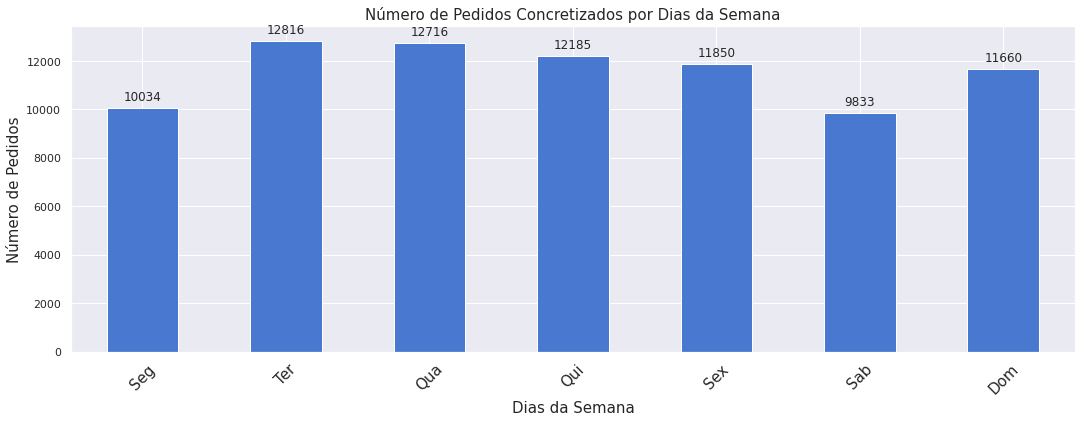

In [30]:
ax = vendas_concretizadas_df.groupby('order_id')['dia_da_semana'].unique().value_counts().sort_index().plot(kind='bar',figsize=(18,6))
ax.set_xlabel('Dias da Semana',fontsize=15)
ax.set_ylabel('Número de Pedidos',fontsize=15)
ax.set_title('Número de Pedidos Concretizados por Dias da Semana',fontsize=15)
ax.set_xticklabels(('Seg','Ter','Qua','Qui','Sex','Sab', 'Dom'), rotation='45', fontsize=15)

def adicionar_valores_no_grafico(ax, spacing=5):


    
    # Para cada barra, seta um label
    for rect in ax.patches:
        # Pega o valor de cada X e Y de cada retângulo
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        
        space = spacing
        va = 'bottom'

        
        label = "{:.0f}".format(y_value)

        # Criar anotação no gráfico
        ax.annotate(
            label,                      
            (x_value, y_value),         
            xytext=(0, space),          
            textcoords="offset points", 
            ha='center',                
            va=va)                      
                                        


#Chama a função novamente para passar os valores do gráfico antes da plotagem final
adicionar_valores_no_grafico(ax)

plt.show()


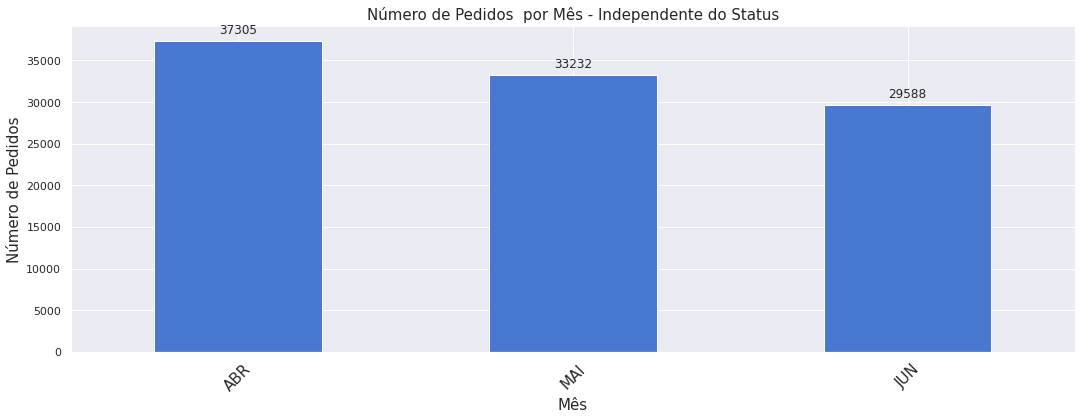

In [31]:
ax4 = df_orders.groupby('order_id')['mes'].unique().value_counts().sort_index().plot(kind='bar',figsize=(18,6))
ax4.set_xlabel('Mês',fontsize=15)
ax4.set_ylabel('Número de Pedidos',fontsize=15)
ax4.set_title('Número de Pedidos  por Mês - Independente do Status',fontsize=15)
ax4.set_xticklabels(('ABR','MAI','JUN'), rotation='45', fontsize=15)
adicionar_valores_no_grafico(ax4)

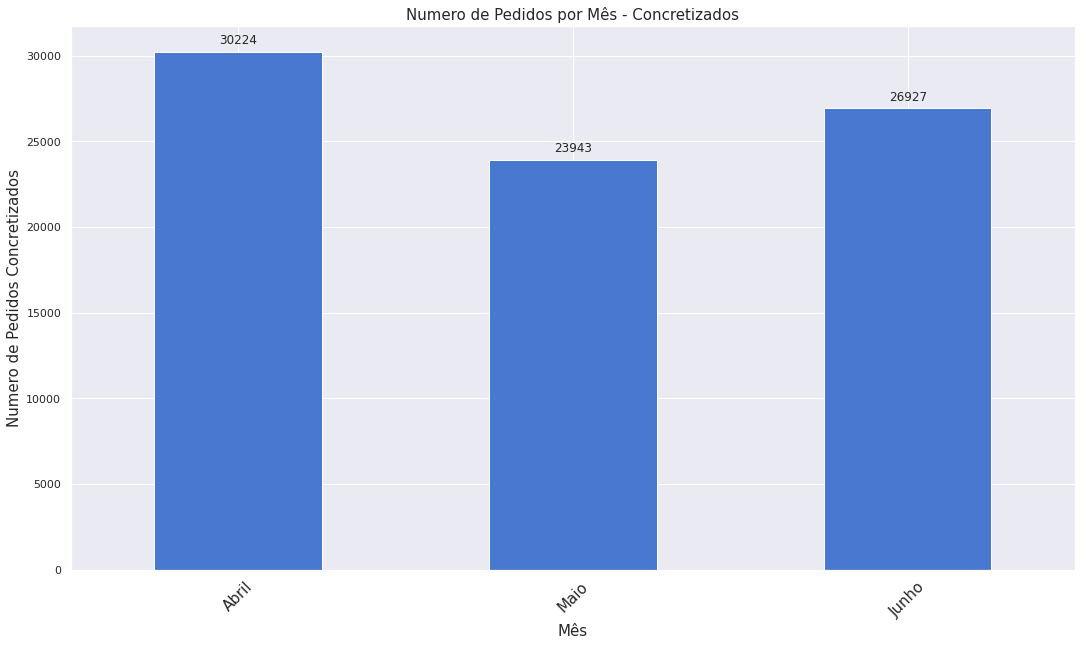

In [32]:
ax1 = vendas_concretizadas_df.groupby('order_id')['nome_do_mes'].unique().value_counts().sort_index().plot(kind='bar',figsize=(18,10))
ax1.set_xlabel('Mês',fontsize=15)
ax1.set_ylabel('Numero de Pedidos Concretizados',fontsize=15)
ax1.set_title('Numero de Pedidos por Mês - Concretizados',fontsize=15)
ax1.set_xticklabels(('Abril', 'Maio', 'Junho'), rotation='45', fontsize=15)
adicionar_valores_no_grafico(ax1)
plt.show()

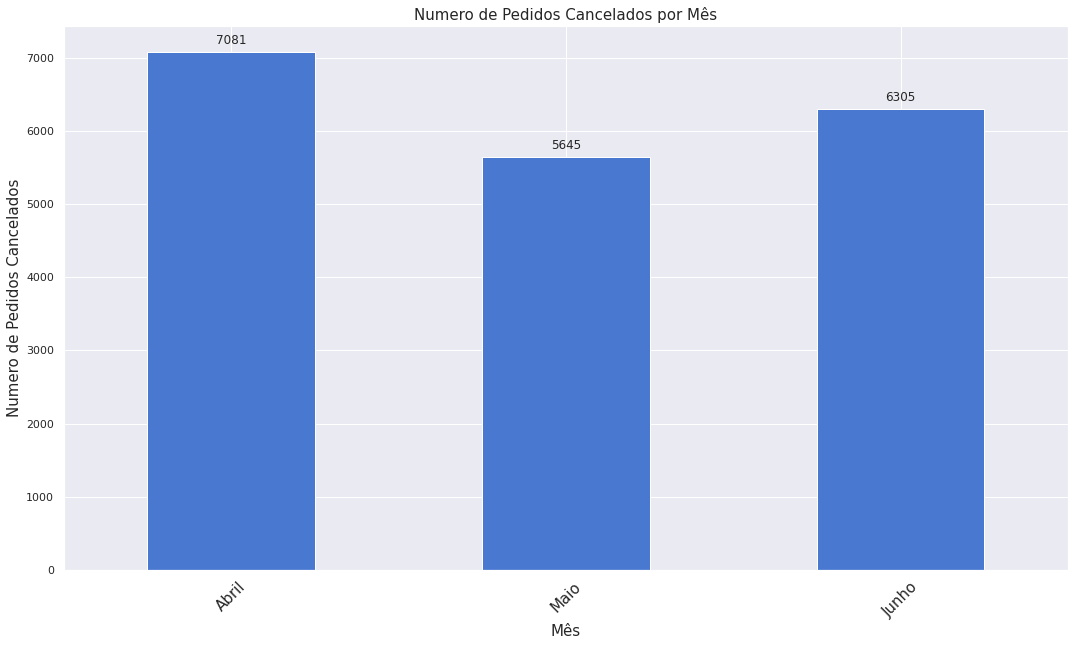

In [33]:
ax2 = vendas_canceladas_df.groupby('order_id')['nome_do_mes'].unique().value_counts().sort_index().plot(kind='bar',figsize=(18,10))
ax2.set_xlabel('Mês',fontsize=15)
ax2.set_ylabel('Numero de Pedidos Cancelados',fontsize=15)
ax2.set_title('Numero de Pedidos Cancelados por Mês',fontsize=15)
ax2.set_xticklabels(('Abril', 'Maio', 'Junho'), rotation='45', fontsize=15)
adicionar_valores_no_grafico(ax2)
plt.show()

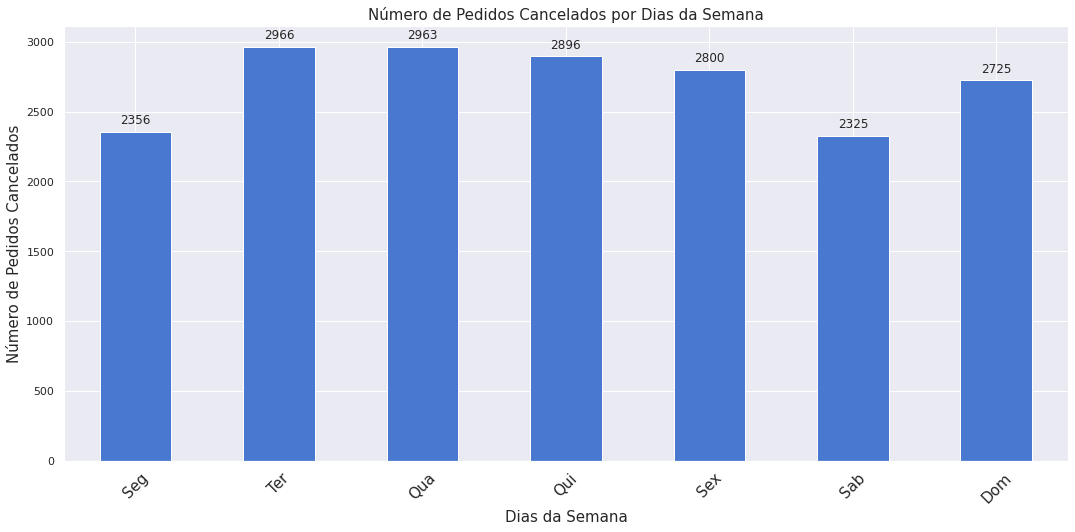

In [34]:
ax3 = vendas_canceladas_df.groupby('order_id')['dia_da_semana'].unique().value_counts().sort_index().plot(kind='bar',figsize=(18,8))
sns.set(palette='muted', color_codes=True)
sns.set_style('white',  {'axes.grid' : False})
ax3.set_xlabel('Dias da Semana',fontsize=15)
ax3.set_ylabel('Número de Pedidos Cancelados',fontsize=15)
ax3.set_title('Número de Pedidos Cancelados por Dias da Semana',fontsize=15)
ax3.set_xticklabels(('Seg','Ter','Qua','Qui','Sex','Sab', 'Dom'), rotation='45', fontsize=15)
adicionar_valores_no_grafico(ax3)
plt.show()

#Quais são os produtos mais desejados entre nossos clientes?

Apesar de não termos o nome do produto e somente o `id`, podemos verificar quais são os produtos mais desejados entre nossos clientes.

Para isso faremos a importação da biblioteca `squarify` que nada mais faz do que a visualização de um `TreeMap` - ou seja, é uma técnica de visualização para representar dados hierárquicos usando retângulos aninhados.

In [35]:
!pip install squarify

In [36]:
#Definindo uma paleta de tons de azul
import matplotlib
cmap = matplotlib.cm.Blues
mini = min(df_orders.product_id.value_counts())
maxi = max(df_orders.product_id.value_counts())
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(i)) for i in df_orders.product_id.value_counts()]

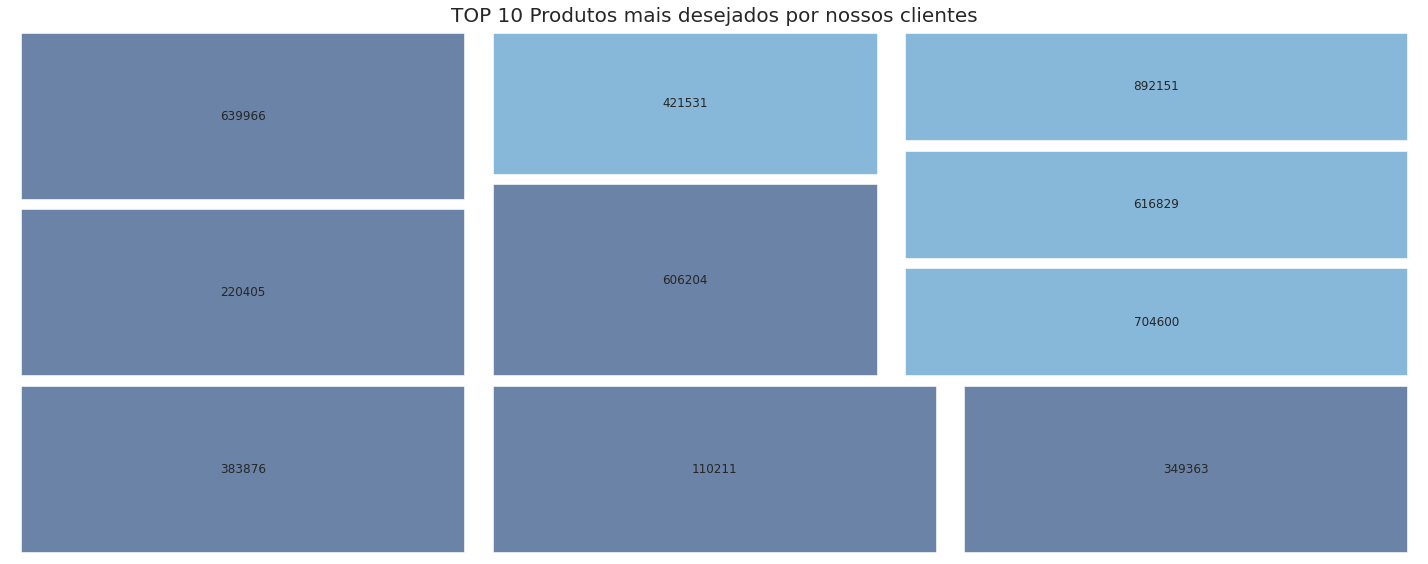

In [37]:
import squarify
#Fazendo o Treemap
produtos_mais_populares_n = 10
produtos_mais_populares = df_orders.loc[:,'product_id'].value_counts()[:produtos_mais_populares_n].sort_values(ascending=False)
squarify.plot(sizes=produtos_mais_populares, label=produtos_mais_populares.index.array, color=colors, pad=True, alpha=.6, text_kwargs={'fontsize': 12});

#Adicionando um título
plt.title("TOP 10 Produtos mais desejados por nossos clientes", fontsize = 20)
#Removendo os eixo
plt.axis('off')
#Ajusta o gráfico
plt.tight_layout()

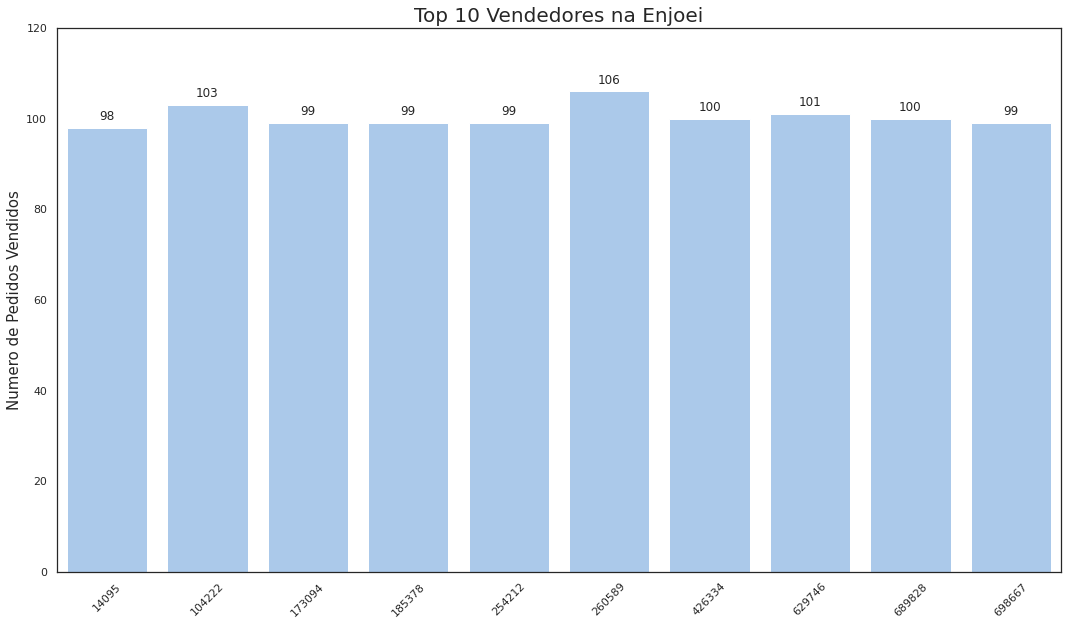

In [38]:
plt.figure(figsize=(18,10))
plt.ylim(0,120)
ax5 = sns.set_color_codes("pastel")
ax5=sns.barplot(vendas_concretizadas_df['seller_id'].value_counts()[:10].index,vendas_concretizadas_df['seller_id'].value_counts()[:10].values,color="b")
ax5.set_title('Top 10 Vendedores na Enjoei', fontsize = 20)
ax5.set_ylabel('Numero de Pedidos Vendidos',fontsize=15)
ax5.set_xticklabels(ax5.get_xticklabels(),rotation=45)
adicionar_valores_no_grafico(ax5)

plt.show()

#Usando um pouco de SQL para continuar nossas análises dentro do dataset de pedidos.

<img src='https://res.cloudinary.com/practicaldev/image/fetch/s--pm-Ir6Fz--/c_imagga_scale,f_auto,fl_progressive,h_420,q_auto,w_1000/https://dev-to-uploads.s3.amazonaws.com/i/05l3as7cuvgm9mjt8ecu.png' width = '1400' height = '400'>

Abaixo usaremos uma biblioteca chamada `pandasql` que nos permite usar `SQLite` para fazermos análises dentro dos notebooks como este.

Olhando nosso dataset eu fiquei curioso em quantas vendas estavam sendo concluídas ou deixando de serem concluídas pelos nossos clientes. 

Por essa razão, construímos a query abaixo.

In [39]:
query = """

WITH vendas_por_dia_da_semana as(

select 
 buyer_id
,count(order_value) as qtd_compras
,SUM (CASE WHEN order_status == 'completed' THEN order_value ELSE 0 END) as vendas_concretizadas
,SUM (CASE WHEN order_status == 'canceled'  THEN order_value ELSE 0 END) as vendas_canceladas
,CAST(ROUND(100 * SUM(CASE WHEN order_status == 'completed' THEN 1 ELSE 0 END) / (COUNT(*)),2)AS FLOAT) as percentage_vendas_concluidas
,CAST(ROUND(100 * SUM(CASE WHEN order_status == 'canceled' THEN 1 ELSE 0 END) / (COUNT(*)),2)AS FLOAT) as percentage_vendas_nao_concluidas

from df_orders

group by buyer_id
order by buyer_id, vendas_concretizadas
)
select *
from vendas_por_dia_da_semana

"""

df_orders_filtered = sqldf(query)
df_orders_filtered.head(10)

buyer_id  qtd_compras  vendas_concretizadas  vendas_canceladas  \
0         6            2                266.15               0.00   
1        24            1                 93.44               0.00   
2        35            9               1124.15               0.00   
3        37            1                155.40               0.00   
4       138            1                132.92               0.00   
5       170            2                293.68               0.00   
6       188            4                375.43             135.56   
7       207            1                209.06               0.00   
8       252            3                306.61             138.30   
9       281            1                109.78               0.00   

   percentage_vendas_concluidas  percentage_vendas_nao_concluidas  
0                         100.0                               0.0  
1                         100.0                               0.0  
2                         100.0                               0.0  
3                         100.0                               0.0  
4                         100.0                               0.0  
5                         100.0                               0.0  
6                          75.0                              25.0  
7                         100.0                               0.0  
8                          66.0                              33.0  
9                         100.0                               0.0

In [40]:
df_orders_filtered.loc[df_orders_filtered['percentage_vendas_nao_concluidas'] > 0].filter(df_orders_filtered['buyer_id'].unique())

Empty DataFrame
Columns: []
Index: [6, 8, 11, 12, 14, 15, 17, 20, 28, 32, 35, 40, 41, 47, 49, 55, 58, 63, 64, 65, 66, 67, 68, 73, 76, 78, 85, 92, 93, 94, 95, 98, 99, 101, 103, 108, 109, 110, 111, 114, 115, 117, 119, 122, 124, 126, 133, 134, 136, 138, 140, 142, 143, 144, 148, 150, 151, 152, 154, 160, 162, 163, 165, 168, 175, 179, 182, 184, 186, 187, 188, 190, 191, 198, 199, 201, 202, 207, 209, 219, 222, 224, 225, 232, 235, 237, 238, 239, 242, 245, 246, 248, 251, 255, 257, 260, 261, 262, 263, 267, ...]

[12224 rows x 0 columns]

##Com a análise acima, podemos ver que **12224** clientes cancelaram as compras conosco.

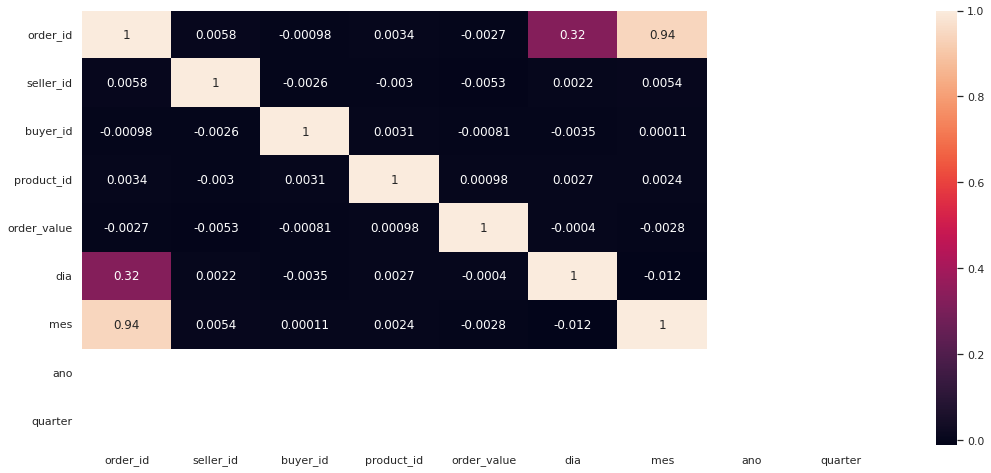

In [41]:
plt.figure(figsize=(18,8))

sns.heatmap(df_orders.corr(), annot=True) 

In [42]:
df_funnel['carts_percentage'] = (df_funnel['carts_created'].sum() / df_funnel['product_views']) * 100
df_funnel['visits_percentage'] = (df_funnel['visits'] / df_funnel['visits'].sum()) * 100
df_funnel['product_percentage'] = (df_funnel['product_views'] / df_funnel['product_views'].sum()) * 100

df_funnel

date  visits  product_views  carts_created  dia  mes   ano  quarter  \
0  2020-04-22   22096          30577           3072   22    4  2020        2   
1  2020-04-03   20300          28215           3082    3    4  2020        2   
2  2020-04-23   22127          28198           3085   23    4  2020        2   
3  2020-06-14   18412          21885           2318   14    6  2020        2   
4  2020-05-19   21911          22663           2330   19    5  2020        2   
..        ...     ...            ...            ...  ...  ...   ...      ...   
86 2020-06-18   23379          23545           2550   18    6  2020        2   
87 2020-04-19   17458          23609           2552   19    4  2020        2   
88 2020-06-26   22024          26325           2811   26    6  2020        2   
89 2020-04-09   21885          27904           2812    9    4  2020        2   
90 2020-05-01   20938          25246           2559    1    5  2020        2   

   dia_da_semana  carts_percentage  visits_percentage  product_percentage  
0         Quarta        775.877293           1.164871            1.353570  
1          Sexta        840.829346           1.070188            1.249010  
2         Quinta        841.336265           1.166505            1.248258  
3        Domingo       1084.030158           0.970655            0.968796  
4          Terça       1046.816397           1.155118            1.003236  
..           ...               ...                ...                 ...  
86        Quinta       1007.602463           1.232509            1.042280  
87       Domingo       1004.871024           0.920362            1.045114  
88         Sexta        901.196581           1.161075            1.165344  
89        Quinta        850.200688           1.153747            1.235243  
90         Sexta        939.713222           1.103822            1.117580  

[91 rows x 12 columns]

In [43]:
df_orders

order_id    sold_at  seller_id  buyer_id  product_id  shipped_at  \
0         518069 2020-06-19     783168    516403      430686         NaN   
1         518098 2020-06-19     693688    826469      246600         NaN   
2         518110 2020-06-19     954809    135963       37480         NaN   
3         518216 2020-06-19     226353     96858      667615         NaN   
4         518555 2020-06-19     504580    908294       82804         NaN   
...          ...        ...        ...       ...         ...         ...   
100120    516964 2020-06-18     163113    108843      539059  2020-06-18   
100121    517319 2020-06-18     722425    133394       15067  2020-06-18   
100122    517584 2020-06-18      55346    301664       31908  2020-06-18   
100123    517610 2020-06-18      60310    447732      301470  2020-06-18   
100124    516758 2020-06-18     430274    499654      174351  2020-06-18   

       order_status  order_value  dia  mes   ano  quarter nome_do_mes mes_ano  \
0          canceled       105.71   19    6  2020        2         Jun  062020   
1          canceled       179.25   19    6  2020        2         Jun  062020   
2          canceled        91.91   19    6  2020        2         Jun  062020   
3          canceled       177.73   19    6  2020        2         Jun  062020   
4          canceled       134.20   19    6  2020        2         Jun  062020   
...             ...          ...  ...  ...   ...      ...         ...     ...   
100120    completed       183.05   18    6  2020        2         Jun  062020   
100121    completed       124.33   18    6  2020        2         Jun  062020   
100122    completed       127.94   18    6  2020        2         Jun  062020   
100123    completed        64.62   18    6  2020        2         Jun  062020   
100124    completed       135.83   18    6  2020        2         Jun  062020   

       dia_da_semana  
0              Sexta  
1              Sexta  
2              Sexta  
3              Sexta  
4              Sexta  
...              ...  
100120        Quinta  
100121        Quinta  
100122        Quinta  
100123        Quinta  
100124        Quinta  

[100125 rows x 15 columns]

#RFM Análise

Essa técnica nos permite uma maior compreensão do nosso cliente e de quando foi a última data e quantas vezes ele fechou negócio com a nossa loja, mostrando o quanto foi gasto.

<img src='https://miro.medium.com/max/1276/1*JlJdMqpZWAWh4_rB1HbSdw.png' width = '600' height = '300'>

`R` : Quantos dias fazem que o cliente comprou?

`F` : Quantas compras nosso cliente fechou desde que conheceu nossa loja?

`M` : Quantos reais nosso cliente gastou na nossa empresa?


Seguiremos a seguinte metodologia [O que é RFM e como aplicá-lo ao seu time de Customer Success](https://medium.com/maxmilhas-tech/o-que-%C3%A9-rfm-e-como-aplic%C3%A1-lo-ao-seu-time-de-customer-service-b9c35817ed01)



In [44]:
query = """

WITH rfm_analise as(

select 
 distinct(buyer_id)
 ,MAX(DATE(sold_at)) as recencia
 ,COUNT(DISTINCT (order_id)) as frequencia
 ,SUM(order_value) as monetariedade

FROM df_orders

WHERE order_status <> 'canceled'
GROUP BY buyer_id
ORDER BY monetariedade DESC


)
select *
from rfm_analise

"""

rfm_orders = sqldf(query)
rfm_orders

buyer_id    recencia  frequencia  monetariedade
0        595840  2020-06-28          38        5676.23
1        786797  2020-06-30          36        4807.04
2         31546  2020-06-26          33        4798.73
3        605051  2020-06-26          37        4790.44
4        415885  2020-06-30          38        4754.73
...         ...         ...         ...            ...
31572    150847  2020-05-01           1          45.03
31573    781643  2020-06-28           1          45.03
31574    420268  2020-05-04           1          45.02
31575    842002  2020-06-13           1          45.02
31576    413662  2020-06-29           1          45.01

[31577 rows x 4 columns]

In [45]:
#Não há valores NULOS em nosso dataset
rfm_orders.isna().sum()

buyer_id         0
recencia         0
frequencia       0
monetariedade    0
dtype: int64

In [46]:
# Mudar a coluna 'recente' para a diferença de dias comparada com a última data de compra

rfm_orders['recencia'] = pd.to_datetime(rfm_orders['recencia'])
ultima_data = rfm_orders['recencia'].max() + pd.to_timedelta(1, 'D')

rfm_orders['recencia'] = ultima_data - rfm_orders['recencia']
rfm_orders['recencia'] = rfm_orders['recencia'].dt.days

rfm_orders.head(10)

buyer_id  recencia  frequencia  monetariedade
0    595840         3          38        5676.23
1    786797         1          36        4807.04
2     31546         5          33        4798.73
3    605051         5          37        4790.44
4    415885         1          38        4754.73
5    530368         2          37        4711.32
6    714429         7          39        4666.74
7    835117         3          34        4636.29
8     96880         7          30        4583.05
9    853101         5          33        4492.62

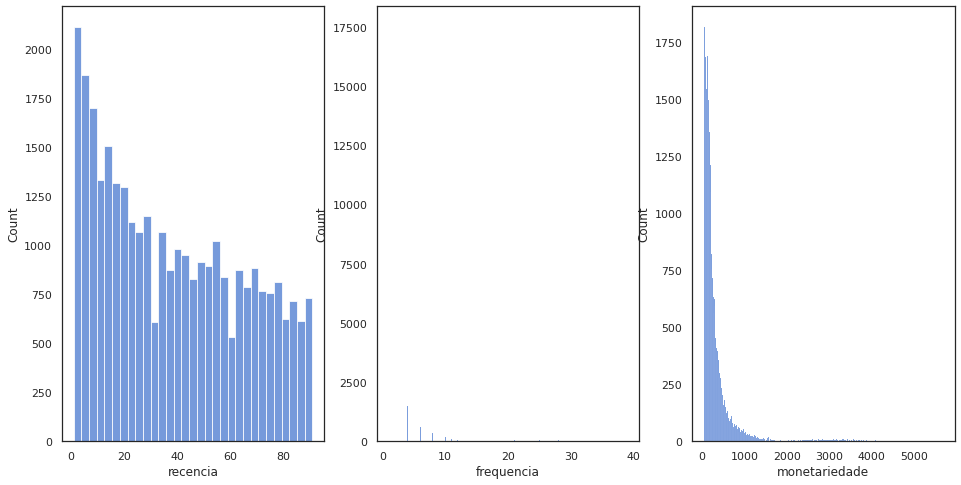

In [47]:
# Verificar se os valores de RFM estão distorcidos pela visualização
fig, axes = plt.subplots(1, 3, figsize = (16, 8))
axes = axes.flatten()

for col, ax in zip(['recencia', 'frequencia', 'monetariedade'], axes):
  sns.histplot(rfm_orders[col], ax = ax)

plt.show()

In [48]:
percentis = [0.25, 0.5, 0.75, 0.9, 0.99]
rfm_orders.recencia.describe(percentis)

count    31577.000000
mean        38.200906
std         26.608231
min          1.000000
25%         14.000000
50%         34.000000
75%         60.000000
90%         78.000000
99%         90.000000
max         91.000000
Name: recencia, dtype: float64

In [49]:
rfm_orders.frequencia.describe(percentis)

count    31577.000000
mean         2.568135
std          3.721823
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
90%          5.000000
99%         24.000000
max         39.000000
Name: frequencia, dtype: float64

In [50]:
rfm_orders.monetariedade.describe(percentis)

count    31577.000000
mean       332.434999
std        490.330889
min         45.010000
25%        112.910000
50%        187.040000
75%        341.130000
90%        662.804000
99%       3086.944000
max       5676.230000
Name: monetariedade, dtype: float64

In [51]:
# Recencia: quanto menor o valor da recencia, maior a pontuação.
rfm_orders['PTS_recencia'] = pd.qcut(rfm_orders['recencia'], 5, labels = [5, 4, 3, 2, 1])\
                      .astype(str)

rfm_orders['PTS_frequencia'] = rfm_orders['frequencia'].apply(lambda x : '1' if x == 1 else '2')

rfm_orders['PTS_monetariedade'] = pd.qcut(rfm_orders['monetariedade'], 5, labels = [1, 2, 3, 4, 5])\
                      .astype(str)
#Dividimos em 5 grupos por percentis, no caso da frequencia dividimos em um grupo já que seus valores em sua maioria se aproximam ou são 1

In [52]:
print(
    rfm_orders['PTS_recencia'].value_counts(normalize = True).sort_index(), '\n\n',
    rfm_orders['PTS_frequencia'].value_counts(normalize = True).sort_index(), '\n\n',
    rfm_orders['PTS_monetariedade'].value_counts(normalize = True).sort_index()
)

1    0.194699
2    0.204548
3    0.190962
4    0.202046
5    0.207746
Name: PTS_recencia, dtype: float64 

 1    0.553979
2    0.446021
Name: PTS_frequencia, dtype: float64 

 1    0.200019
2    0.199987
3    0.200019
4    0.199987
5    0.199987
Name: PTS_monetariedade, dtype: float64


#Conclusão RFM

<img src='https://vidadeproduto.com.br/wp-content/uploads/2020/06/analise-RFM.png' width = '600' height = '300'>



É dever do analista de negócio pesar a pontuação de RFM para encontrar o peso adequado para aplicar a característica da empresa.

Para estratégias de Marketing, poderíamos por exemplo supor que o cliente com pontuação **RFM**(1,1,5) que *ele poderia deixar de comprar em um futuro próximo*.

Assim como o cliente **RFM**(5,5,5) como *VIP* e até mesmo o cliente **RFM**(5,5,2) como os primeiros casos abaixo como *cliente fiel*.

In [53]:
rfm_orders

buyer_id  recencia  frequencia  monetariedade PTS_recencia  \
0        595840         3          38        5676.23            5   
1        786797         1          36        4807.04            5   
2         31546         5          33        4798.73            5   
3        605051         5          37        4790.44            5   
4        415885         1          38        4754.73            5   
...         ...       ...         ...            ...          ...   
31572    150847        61           1          45.03            2   
31573    781643         3           1          45.03            5   
31574    420268        58           1          45.02            2   
31575    842002        18           1          45.02            4   
31576    413662         2           1          45.01            5   

      PTS_frequencia PTS_monetariedade  
0                  2                 5  
1                  2                 5  
2                  2                 5  
3                  2                 5  
4                  2                 5  
...              ...               ...  
31572              1                 1  
31573              1                 1  
31574              1                 1  
31575              1                 1  
31576              1                 1  

[31577 rows x 7 columns]

#Clusterização de Clientes

<img src='https://static.vecteezy.com/ti/vetor-gratis/p2/2042990-cliente-avaliacoes-conceito-pessoas-dando-estrelas-avaliacao-feedback-satisfacao-e-avaliacao-flat-vector-illustration-vetor.jpg' width = '500' height = '400'>

O interesse na clusterização de clientes - como mencionado acima pelo método RFM e alinhado junto ao time de Marketing é para criar campanhas direcionadas para nosso público alvo.

Artigo interessante sobre como definir o número de cluster para o K-Means [clique aqui](https://medium.com/pizzadedados/kmeans-e-metodo-do-cotovelo-94ded9fdf3a9#:~:text=O%20M%C3%A9todo%20do%20Cotovelo&text=Como%20o%20KMeans%20calcula%20a,dist%C3%A2ncia%20seja%20a%20menor%20vi%C3%A1vel.) 

Usaremos esse método a seguir.

In [54]:
#Importar funções do SciKit Learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from mpl_toolkits.mplot3d import Axes3D

In [55]:
mms = MinMaxScaler()

rfm_orders_cluster = rfm_orders[['recencia', 'frequencia', 'monetariedade']]

rfm_orders_scaled = mms.fit_transform(rfm_orders_cluster)
rfm_orders_scaled = pd.DataFrame(rfm_orders_scaled, columns = ['recencia', 'frequencia', 'monetariedade'])
rfm_orders_scaled.head()

recencia  frequencia  monetariedade
0  0.022222    0.973684       1.000000
1  0.000000    0.921053       0.845648
2  0.044444    0.842105       0.844172
3  0.044444    0.947368       0.842700
4  0.000000    0.973684       0.836359

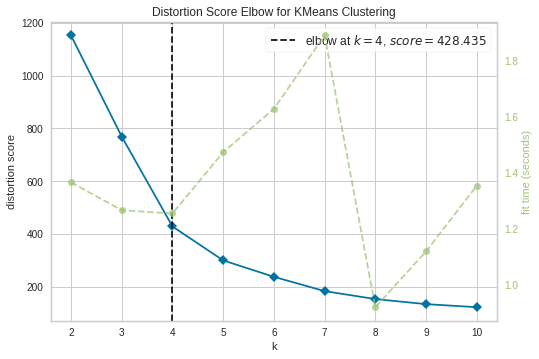

In [56]:
#Usar o Método do Cotovelo - ELBOW METHOD
k_means = KMeans()

elbow = KElbowVisualizer(estimator = k_means, k = 10)
elbow.fit(rfm_orders_scaled)
elbow.show()

plt.show()

In [57]:
k_means = KMeans(n_clusters = 4, random_state = 42)
clusters = k_means.fit_predict(rfm_orders_scaled)

rfm_orders_scaled['cluster'] = clusters
rfm_orders_scaled

recencia  frequencia  monetariedade  cluster
0      0.022222    0.973684       1.000000        3
1      0.000000    0.921053       0.845648        3
2      0.044444    0.842105       0.844172        3
3      0.044444    0.947368       0.842700        3
4      0.000000    0.973684       0.836359        3
...         ...         ...            ...      ...
31572  0.666667    0.000000       0.000004        2
31573  0.022222    0.000000       0.000004        1
31574  0.633333    0.000000       0.000002        0
31575  0.188889    0.000000       0.000002        1
31576  0.011111    0.000000       0.000000        1

[31577 rows x 4 columns]

Text(0.5, 0.92, 'Plot em 3D dos Clusters')

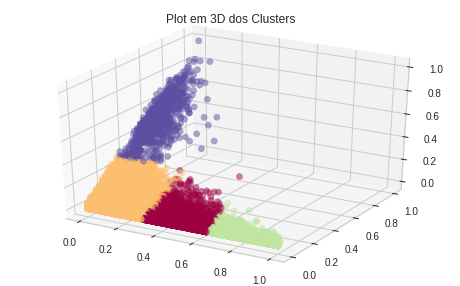

In [58]:
x = rfm_orders_scaled['recencia']
y = rfm_orders_scaled['frequencia']
z = rfm_orders_scaled['monetariedade']

fig = plt.figure(figsize = (8,5))
ax = plt.subplot(111, projection = '3d')
ax.scatter(x, y, z, s=40, c = rfm_orders_scaled['cluster'], marker = 'o', alpha = 0.5, cmap = 'Spectral')
ax.set_title('Plot em 3D dos Clusters')

In [59]:
rfm_orders['cluster'] = rfm_orders_scaled['cluster']
rfm_orders['cluster'].value_counts().sort_index()

0     9755
1    12706
2     8362
3      754
Name: cluster, dtype: int64

In [60]:
rfm_orders.pivot_table(index = 'cluster', values = ['recencia', 'frequencia', 'monetariedade'], aggfunc = ['mean', 'std'])

mean                                 std                        
        frequencia monetariedade   recencia frequencia monetariedade  recencia
cluster                                                                       
0         1.713173    221.555947  42.750077   1.165400    167.277288  9.014675
1         2.941996    379.798486  12.919802   2.406803    324.172011  7.852824
2         1.187993    154.329894  74.271227   0.495220     90.894460  9.447979
3        22.635279   2944.025955   5.342175   5.157892    689.726011  4.742187

#Calculando os pesos para cada R,F,M

O artigo que mencionei acima fala sobre a Tese RFM - Data Driven Selection Methods of Weights in RFM Model e pode ser encontrada na página **46** da Tese [clique aqui](https://oak.jejunu.ac.kr/bitstream/2020.oak/23663/2/RFM%20%EB%AA%A8%ED%98%95%EC%9D%98%20%EA%B0%80%EC%A4%91%EC%B9%98%20%EC%84%A0%ED%83%9D%EC%97%90%20%EA%B4%80%ED%95%9C%20%EC%97%B0%EA%B5%AC.pdf) 


In [61]:
tmp = rfm_orders.pivot_table(index = 'cluster', values = ['recencia', 'frequencia', 'monetariedade'], aggfunc = ['mean', 'std'])

In [62]:
#Calculando o Coeficiente de Variação

cv_r_0 = tmp[('std', 'recencia')][0] / tmp[('mean', 'recencia')][0]
cv_r_1 = tmp[('std', 'recencia')][1] / tmp[('mean', 'recencia')][1]
cv_r_2 = tmp[('std', 'recencia')][2] / tmp[('mean', 'recencia')][2]
cv_r_3 = tmp[('std', 'recencia')][3] / tmp[('mean', 'recencia')][3]

w_r = np.min([cv_r_0, cv_r_1, cv_r_2, cv_r_3]) / np.sum([cv_r_0, cv_r_1, cv_r_2, cv_r_3])
w_r

0.06937747447730325

In [63]:
cv_f_0 = tmp[('std', 'frequencia')][0] / tmp[('mean', 'frequencia')][0]
cv_f_1 = tmp[('std', 'frequencia')][1] / tmp[('mean', 'frequencia')][1]
cv_f_2 = tmp[('std', 'frequencia')][2] / tmp[('mean', 'frequencia')][2]
cv_f_3 = tmp[('std', 'frequencia')][3] / tmp[('mean', 'frequencia')][3]

w_f = np.min([cv_f_0, cv_f_1, cv_f_2, cv_f_3]) / np.sum([cv_f_0, cv_f_1, cv_f_2, cv_f_3])
w_f

0.10632874922069038

In [64]:
cv_m_0 = tmp[('std', 'monetariedade')][0] / tmp[('mean', 'monetariedade')][0]
cv_m_1 = tmp[('std', 'monetariedade')][1] / tmp[('mean', 'monetariedade')][1]
cv_m_2 = tmp[('std', 'monetariedade')][2] / tmp[('mean', 'monetariedade')][2]
cv_m_3 = tmp[('std', 'monetariedade')][3] / tmp[('mean', 'monetariedade')][3]

w_m = np.min([cv_m_0, cv_m_1, cv_m_2, cv_m_3]) / np.sum([cv_m_0, cv_m_1, cv_m_2, cv_m_3])
w_m

0.09634048726486451

In [65]:
W_R = w_r / (w_r + w_f + w_m)
W_F = w_f / (w_r + w_f + w_m)
W_M = w_m / (w_r + w_f + w_m)

print(f'Peso da Recencia  : {W_R}')
print(f'Peso da Frequencia: {W_F}')
print(f'Peso da Monetariedade : {W_M}')
print(f'Total da Soma dos Pesos: {np.sum([W_R, W_F, W_M])}')

Peso da Recencia  : 0.2550204493623714
Peso da Frequencia: 0.3908473983911064
Peso da Monetariedade : 0.3541321522465222
Total da Soma dos Pesos: 1.0


In [66]:
rfm_orders['PTS_RFM'] = (rfm_orders['PTS_recencia'].astype('int64') * W_R / 5 * 100 \
                        + rfm_orders['PTS_frequencia'].astype('int64') * W_F / 2 * 100 \
                        + rfm_orders['PTS_monetariedade'].astype('int64') * W_M / 5 * 100)

rfm_orders

buyer_id  recencia  frequencia  monetariedade PTS_recencia  \
0        595840         3          38        5676.23            5   
1        786797         1          36        4807.04            5   
2         31546         5          33        4798.73            5   
3        605051         5          37        4790.44            5   
4        415885         1          38        4754.73            5   
...         ...       ...         ...            ...          ...   
31572    150847        61           1          45.03            2   
31573    781643         3           1          45.03            5   
31574    420268        58           1          45.02            2   
31575    842002        18           1          45.02            4   
31576    413662         2           1          45.01            5   

      PTS_frequencia PTS_monetariedade  cluster     PTS_RFM  
0                  2                 5        3  100.000000  
1                  2                 5        3  100.000000  
2                  2                 5        3  100.000000  
3                  2                 5        3  100.000000  
4                  2                 5        3  100.000000  
...              ...               ...      ...         ...  
31572              1                 1        2   36.825831  
31573              1                 1        1   52.127058  
31574              1                 1        0   36.825831  
31575              1                 1        1   47.026649  
31576              1                 1        1   52.127058  

[31577 rows x 9 columns]

In [67]:
rfm_orders.PTS_RFM.describe()

count    31577.000000
mean        64.927716
std         22.702126
min         31.725422
25%         45.890708
50%         59.209701
75%         87.816948
max        100.000000
Name: PTS_RFM, dtype: float64

In [68]:
rfm_orders.pivot_table(index = 'PTS_RFM', values = ['recencia', 'frequencia', 'monetariedade'], aggfunc = ['mean', 'count'])

mean                               count                \
           frequencia monetariedade   recencia frequencia monetariedade   
PTS_RFM                                                                   
31.725422    1.000000     70.477206  79.191577       1947          1947   
36.825831    1.000000     70.543996  55.979490       1609          1609   
38.808065    1.000000    125.989128  79.056243       1778          1778   
41.926240    1.000000     70.676934  35.699559       1135          1135   
43.908474    1.000000    126.603993  55.796491       1425          1425   
45.890708    1.000000    185.710129  78.662599       1393          1393   
47.026649    1.000000     71.021979  19.070588        935           935   
49.008883    1.000000    126.140729  35.681773       1015          1015   
50.991117    1.000000    185.989168  55.650613       1142          1142   
52.127058    1.000000     71.351977   5.796486        683           683   
52.973351    1.000000    263.644939  79.173780        328           328   
54.109292    1.000000    126.675653  18.923950        881           881   
56.091526    1.000000    185.492217  35.542022        821           821   
56.368201    2.000000     94.470000  51.000000          1             1   
58.073760    1.000000    265.415267  56.030534        262           262   
58.350435    2.000000    138.592239  75.373134         67            67   
59.209701    1.000000    126.081020   5.804422        588           588   
61.191935    1.000000    185.859613  18.767802        646           646   
61.468610    2.000000     95.150000  31.000000          3             3   
63.174169    1.000000    262.835134  35.149733        187           187   
63.450844    2.000000    135.745878  55.618321        131           131   
65.433078    2.018072    192.752892  74.518072        166           166   
66.292344    1.000000    187.276868   6.068894        479           479   
66.569019    2.000000     95.410000  23.000000          2             2   
68.274578    1.000000    261.925704  18.785185        135           135   
68.551253    2.000000    134.082847  35.598540        137           137   
70.533487    2.041026    194.338000  54.666667        390           390   
71.669428    2.000000     91.000000  10.000000          1             1   
72.515721    2.142119    303.456925  74.459948        387           387   
73.374987    1.000000    265.591058   5.875000        104           104   
73.651662    2.000000    134.036765  17.717647        170           170   
75.633896    2.067686    194.811921  35.030568        458           458   
77.616130    2.260788    306.630319  54.557223       1066          1066   
78.752071    2.008130    133.185935   5.617886        123           123   
79.598364    2.792683    492.280122  73.158537         82            82   
80.734305    2.069565    195.808522  18.769565        460           460   
82.716539    2.378483    309.301223  34.752322       1292          1292   
84.698773    3.621247    547.821363  53.251732        433           433   
85.834714    2.091413    196.739945   5.673130        361           361   
87.816948    2.451784    313.277578  18.501139       1317          1317   
89.799182    4.394094    612.898635  34.295316        982           982   
92.917357    2.511722    312.375416   5.737268       1237          1237   
94.899591    5.787350    783.873844  17.757361       1834          1834   
100.000000   9.775804   1282.966307   5.177279       2984          2984   

                     
           recencia  
PTS_RFM              
31.725422      1947  
36.825831      1609  
38.808065      1778  
41.926240      1135  
43.908474      1425  
45.890708      1393  
47.026649       935  
49.008883      1015  
50.991117      1142  
52.127058       683  
52.973351       328  
54.109292       881  
56.091526       821  
56.368201         1  
58.073760       262  
58.350435        67  
59.209701       588  
61.191935       646  
61.468610         3  
63.1741

Como discutido previamente na análise, iremos classificar os clientes em 5 grupos de acordo com o Método RFM.

Podemos inferir, é claro, qual cliente vai ser mais útil para o nosso negócio ou até mesmo aquele que está prestes a não repetir mais a compra conosco.

In [69]:
rfm_orders['classe_cliente'] = pd.qcut(rfm_orders.PTS_RFM, 5, labels = [5, 4, 3, 2, 1]).astype('str')
rfm_orders.head(10)

buyer_id  recencia  frequencia  monetariedade PTS_recencia PTS_frequencia  \
0    595840         3          38        5676.23            5              2   
1    786797         1          36        4807.04            5              2   
2     31546         5          33        4798.73            5              2   
3    605051         5          37        4790.44            5              2   
4    415885         1          38        4754.73            5              2   
5    530368         2          37        4711.32            5              2   
6    714429         7          39        4666.74            5              2   
7    835117         3          34        4636.29            5              2   
8     96880         7          30        4583.05            5              2   
9    853101         5          33        4492.62            5              2   

  PTS_monetariedade  cluster  PTS_RFM classe_cliente  
0                 5        3    100.0              1  
1                 5        3    100.0              1  
2                 5        3    100.0              1  
3                 5        3    100.0              1  
4                 5        3    100.0              1  
5                 5        3    100.0              1  
6                 5        3    100.0              1  
7                 5        3    100.0              1  
8                 5        3    100.0              1  
9                 5        3    100.0              1

##ANOVA

<img src='https://www.rmining.com.br/wp-content/uploads/2013/06/ANOVA.png' width = '300' height = '200'>

Usaremos um método estatístico chamado ANOVA para checar se o cliente é significativo para o nosso negócio ou não.



In [70]:
from scipy import stats

In [71]:
cls1_r = rfm_orders[rfm_orders['classe_cliente'] == '1']['recencia']
cls2_r = rfm_orders[rfm_orders['classe_cliente'] == '2']['recencia']
cls3_r = rfm_orders[rfm_orders['classe_cliente'] == '3']['recencia']
cls4_r = rfm_orders[rfm_orders['classe_cliente'] == '4']['recencia']
cls5_r = rfm_orders[rfm_orders['classe_cliente'] == '5']['recencia']

stats.f_oneway(cls1_r, cls2_r, cls3_r, cls4_r, cls5_r)

F_onewayResult(statistic=7454.431244732388, pvalue=0.0)

In [72]:
cls1_f = rfm_orders[rfm_orders['classe_cliente'] == '1']['frequencia']
cls2_f = rfm_orders[rfm_orders['classe_cliente'] == '2']['frequencia']
cls3_f = rfm_orders[rfm_orders['classe_cliente'] == '3']['frequencia']
cls4_f = rfm_orders[rfm_orders['classe_cliente'] == '4']['frequencia']
cls5_f = rfm_orders[rfm_orders['classe_cliente'] == '5']['frequencia']

stats.f_oneway(cls1_f, cls2_f, cls3_f, cls4_f, cls5_f)

F_onewayResult(statistic=4817.0630345136715, pvalue=0.0)

In [73]:
cls1_m = rfm_orders[rfm_orders['classe_cliente'] == '1']['monetariedade']
cls2_m = rfm_orders[rfm_orders['classe_cliente'] == '2']['monetariedade']
cls3_m = rfm_orders[rfm_orders['classe_cliente'] == '3']['monetariedade']
cls4_m = rfm_orders[rfm_orders['classe_cliente'] == '4']['monetariedade']
cls5_m = rfm_orders[rfm_orders['classe_cliente'] == '5']['monetariedade']

stats.f_oneway(cls1_m, cls2_m, cls3_m, cls4_m, cls5_m)

F_onewayResult(statistic=5043.279080211967, pvalue=0.0)

Analisamos acima que nosso **F-statistic** é bem grande e nosso **p-valor** é quase zero, isso significa que finalizamos a nossa classificação e ela é estatísticamente significante.

#Previsões para o Futuro

<img src='https://images.unsplash.com/photo-1485827404703-89b55fcc595e?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1470&q=80' width = '1400' height = '600'>


Abaixo realizaremos uma análise de série temporal utilizando a biblioteca Prophet, do Facebook - ao fazer o uso dessa ferramenta poderemos prever como serão as nossas vendas em um futuro próximo. Mesmo que haja um lapso temporal nos nossos dados, a ferramenta é tão poderosa que consegue fazer uma boa previsão para os novos dias que virão.

In [74]:
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
import folium
from folium.plugins import FastMarkerCluster
from fbprophet import Prophet
import spacy

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPU times: user 3min 17s, sys: 4.36 s, total: 3min 22s
Wall time: 3min 22s


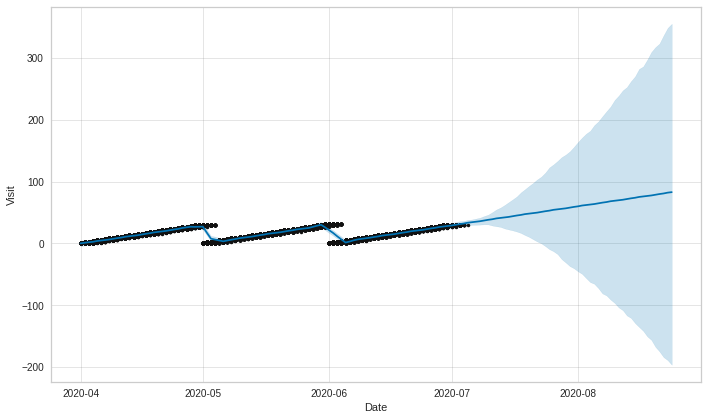

In [75]:
%%time
#Transformar a coluna shipped_at para datetime
vendas_concretizadas_df['shipped_at'] = pd.to_datetime(vendas_concretizadas_df['shipped_at']).dt.date

df_new = vendas_concretizadas_df[['shipped_at', 'dia']].rename(columns = {'shipped_at': 'ds', 'dia': 'y'})
model = Prophet()
model.fit(df_new)
future = model.make_future_dataframe(periods=50)
forecast = model.predict(future)
model.plot(forecast, xlabel = 'Date', ylabel = 'Visit');



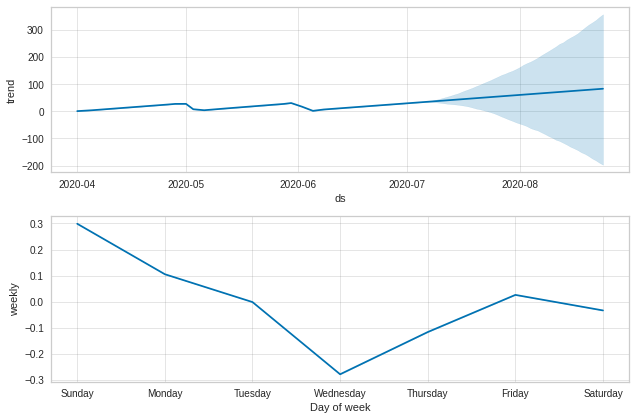

In [76]:
model.plot_components(forecast);

Como observamos acima, existe uma previsão para que haja uma retomada das vendas já na metade de Julho e a partir daí haverá uma crescente ainda em 2020 e irá começar o ano de 2021 com bons números de vendas.

In [77]:
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)

# Conclusões Gerais

<img src='https://images.unsplash.com/photo-1563013544-824ae1b704d3?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1470&q=80' width = '1400' height = '600'>

Desde que os dados foram providos pelas tabelas `orders` e também a tabela `funnel` - fomos capazes de verificar alguns comportamentos desde o primeiro momento, tais como:

Vimos que os meses em que abrangiam essas tabelas eras os meses de **Abril, Maio e Junho**.

Notamos uma drástica *queda de vendas no período de Junho*, bem como *uma queda de visitantes em nossa loja on-line no mesmo período*. Fator que pode e deve estar diretamente relacionado de acordo com os primeiros gráficos.

Outro ponto que nos leva a crer que as vendas caíram, são as taxas de conversão da página de produto para o carrinho - essa taxa de conversão baixa faz com que as vendas em nossa loja online permaneçam baixas em comparação com outros meses do ano. Como solução, indico que possamos traçar junto ao nosso time um redesenho sobre a `Jornada da Compra` ✅ para evitarmos perder nosso cliente tanto na página de produto bem como no abandono do carrinho. 



